In [1]:
import os
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_preimages = "/Users/sakshisharma/Desktop/Mexico/Image/Pre-disaster"
path_postimages = "/Users/sakshisharma/Desktop/Mexico/Image/Post-disaster"

In [3]:
tif_files = [file for file in os.listdir(path_preimages) if file.endswith('.tif')]
pre_tif_files = [file for file in os.listdir(path_preimages) if file.endswith('.tif')]
post_tif_files = [file for file in os.listdir(path_postimages) if file.endswith('.tif')]
print("Total Pre-disaster TIFF files:", len(pre_tif_files))
print("Total Post-disaster TIFF files:", len(post_tif_files))
print("Total TIFF files (Pre + Post):", len(pre_tif_files) + len(post_tif_files))


Total Pre-disaster TIFF files: 724
Total Post-disaster TIFF files: 724
Total TIFF files (Pre + Post): 1448


In [4]:
def fix_image_dtype(image_change):
    if image_change.dtype == np.int8:
        return (image_change.astype(np.int16) + 128).astype(np.uint8)
    return image_change

RGB -> GRAYSCALE CONVERSION : https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/#:~:text=Three%20algorithms%20for%20converting%20color%20to%20grayscale&text=The%20lightness%20method%20averages%20the,version%20of%20the%20average%20method.

In [ ]:
import os
import numpy as np
import tifffile as tiff

# location where the dataset with these folder are stored on my device
path_preimages = "/Users/sakshisharma/Desktop/Mexico/Image/Pre-disaster"
path_postimages = "/Users/sakshisharma/Desktop/Mexico/Image/Post-disaster"

# location where the processed grayscale nyp folders with pre + post images are stores as inputs for my U-Net
save_path = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY_2ch_Grayscale"
os.makedirs(save_path, exist_ok=True)

# listing the files that end with .tif
pre_tif_files = [file for file in os.listdir(path_preimages) if file.endswith('.tif')]
post_tif_files = [file for file in os.listdir(path_postimages) if file.endswith('.tif')]

print("Total Pre-disaster TIFF files:", len(pre_tif_files))
print("Total Post-disaster TIFF files:", len(post_tif_files))
print("Total TIFF files (Pre + Post):", len(pre_tif_files) + len(post_tif_files))


for file in pre_tif_files:  # looping and finding file pairs that exist in both pre and post folders
    if file in post_tif_files:
        base = file.replace(".tif", "")  # if pairs exist-> removes the .tif extension from from the filename -> gets the basename
        output_file = os.path.join(save_path, base + "_input.npy") # adds base name -> then appends "_input.npy" to the filename -> joins them with folder path
        
        if os.path.exists(output_file): # this avoids re-processing files that already exist as .npy.
            continue
        
        
        pre_image = tiff.imread(os.path.join(path_preimages, file)) / 255.0 # loading and normalizing the image 
        post_image = tiff.imread(os.path.join(path_postimages, file)) / 255.0 #loading and normalizing the image

 
        pre_gray = 0.2989 * pre_image[..., 0] + 0.5870 * pre_image[..., 1] + 0.1140 * pre_image[..., 2] #mathematical formula for converting into grayscale 
        post_gray = 0.2989 * post_image[..., 0] + 0.5870 * post_image[..., 1] + 0.1140 * post_image[..., 2]


        combined = np.stack([pre_gray, post_gray], axis=-1) # makes them a 2 channel input array


        np.save(output_file, combined) #Saves the result as a .npy file for training
        print(f"Saved: {output_file}")



Total Pre-disaster TIFF files: 724
Total Post-disaster TIFF files: 724
Total TIFF files (Pre + Post): 1448


In [6]:
arr = np.load("/Users/sakshisharma/Desktop/Mexico/Processed_NPY_2ch_Grayscale/part76cut1h1w_input.npy")
print(arr.shape)  # Should be (512, 512, 2) 

(512, 512, 2)


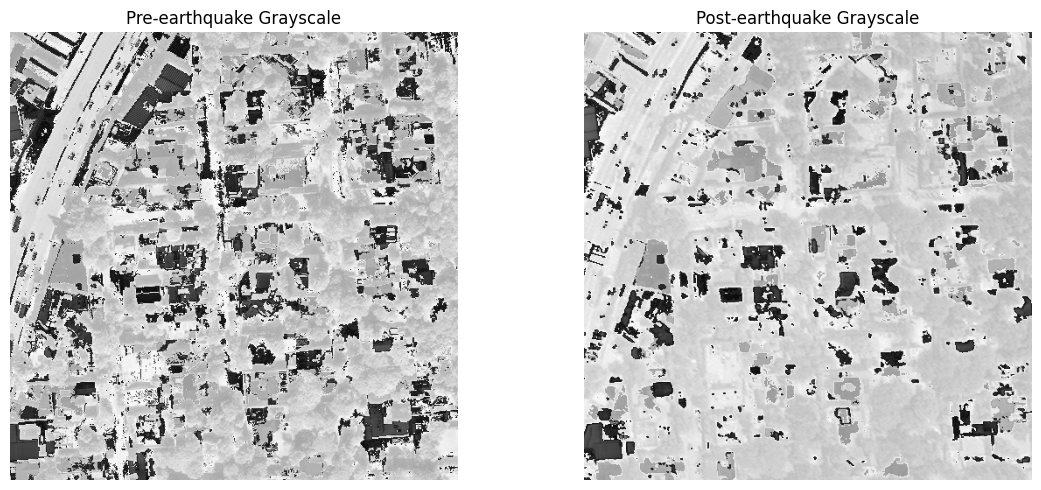

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# loading a normalalized gray scale image -> both pre and post
sample_path = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY_2ch_Grayscale/part76cut1h1w_input.npy"
data = np.load(sample_path)

# Extract channels
pre_gray = data[..., 0]
post_gray = data[..., 1]

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(pre_gray, cmap='gray')
plt.title("Pre-earthquake Grayscale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(post_gray, cmap='gray')
plt.title("Post-earthquake Grayscale")
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
import math

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


custom dataset class used to load data in batches during training for the model to learn -> load npy input arrays, matches label files, feeding data into the model -> 8 samples at a time and shuffle data at every epoch

reference: https://keras.io/api/utils/python_utils/#sequence-class

custom dataset class used to load data in batches during training for the model to learn -> load npy input arrays, matches label files, feeding data into the model -> 8 samples at a time and shuffle data at every epoch

reference: https://keras.io/api/utils/python_utils/#sequence-class

custom dataset class used to load data in batches during training for the model to learn -> load npy input arrays, matches label files, feeding data into the model -> 8 samples at a time and shuffle data at every epoch

reference: https://keras.io/api/utils/python_utils/#sequence-class

In [ ]:
#custom dataset class used to load data in batches during training for the model to learn -> load npy input arrays, matches label files, feeding data into the model -> 8 samples at a time and shuffle data at every epoch

#reference: https://keras.io/api/utils/python_utils/#sequence-class

import os
import numpy as np
import tifffile as tiff
from tensorflow.keras.utils import Sequence

class EarthquakeDamageGenerator(Sequence):
    def __init__(self, input_files, input_path, label_path, batch_size=8, shuffle=True):
        self.input_files = input_files
        self.input_path = input_path
        self.label_path = label_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): # this is to return the number of batches per epoch
        return int(np.ceil(len(self.input_files) / self.batch_size))

    def __getitem__(self, index): # this function is to fetch and return the input and label data for the batch  to the given index.
        batch_files = self.input_files[index * self.batch_size: (index + 1) * self.batch_size]
        return self.__data_generation(batch_files)

    def on_epoch_end(self): # randonly shuffles the input files after every epoch if shuffle is made true
        if self.shuffle:
            np.random.shuffle(self.input_files)

    def __data_generation(self, batch_files):
        X_batch, Y_batch = [], []

        for file in batch_files:
            try:
                base = file.replace("_input.npy", "") # gets label filename by removing _input.npy
            
                input_array = np.load(os.path.join(self.input_path, file), allow_pickle=True) # helps to load the input array from the npy file
                label_array = tiff.imread(os.path.join(self.label_path, base + ".tif")) # Loads the label array from the tif file

                if label_array.ndim == 3: #If label is 3D (e.g., 1x512x512), squeeze to 2D
                    label_array = label_array.squeeze()
                if label_array.shape != (512, 512):  # Only accept labels of shape (512, 512) otherwise skips that sample
                    continue 
                X_batch.append(input_array)  # Append to batch lists
                Y_batch.append(label_array.astype(np.uint8))

            except Exception as e: # Skip files that can't be read or processed and continues
                continue

        return np.array(X_batch), np.array(Y_batch)
        #so this function basically return numpy input array and numpy label array


U-Net Implementation -> reference for unet: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [ ]:
#UNET MODEL -> reference: UNET: reference for unet: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

from tensorflow.keras import layers, models

def conv_block(input_tensor, number_filters):
    con_blk1 = layers.Conv2D(number_filters, 3, padding="same", activation="relu")(input_tensor)
    con_blk2 = layers.Dropout(0.2)(con_blk1)
    con_blk3 = layers.Conv2D(number_filters, 3, padding="same", activation="relu")(con_blk2)
    return con_blk3
#this is encoder
def encoder_block(input_tensor, number_filters):
    encoder_features = conv_block(input_tensor, number_filters)
    pooling_features = layers.MaxPooling2D(2)(encoder_features)
    return pooling_features
#this is decoder
def decoder_block(x, number_filters):
    upsample = layers.UpSampling2D(2)(x)
    x = conv_block(x, number_filters)
    return x

def channel2_unet(input_shape=(512, 512, 2), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    encoder_1 = encoder_block(inputs, 16)  
    encoder_2 = encoder_block(encoder_1, 32)

    # this is Bottleneck
    bottleneck = conv_block(encoder_2, 64)

    decoder_1 = decoder_block(bottleneck, 32)
    decoder_2 = decoder_block(decoder_1, 16)

    #this is output layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(decoder_2)

    return models.Model(inputs, outputs)

# model defining
model = channel2_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 16)   │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 512, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 512, 512, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512, 512, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 512, 512, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 512, 512, 3)    │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,643 (416.57 KB)

 Trainable params: 106,643 (416.57 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from sklearn.model_selection import train_test_split
import os

input_path = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY_2ch_Grayscale"
label_path = "/Users/sakshisharma/Desktop/Mexico/Label"
all_files = sorted([f for f in os.listdir(input_path) if f.endswith("_input.npy")])

# this is for Splitting into 70% train and 30%
train_files, temp = train_test_split(all_files, test_size=0.30, random_state=42)
#here the 30% gets further divided into 15% to both val and test

val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42) 
train_gen = EarthquakeDamageGenerator(train_files, input_path, label_path, batch_size=4)
val_gen = EarthquakeDamageGenerator(val_files, input_path, label_path, batch_size=4)
test_gen = EarthquakeDamageGenerator(test_files, input_path, label_path, batch_size=4)


In [4]:
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Train files: 506
Validation files: 109
Test files: 109


In [5]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import json

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[SparseCategoricalAccuracy()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_unet_model_2ch_Grayscale.h5", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

with open("training_history_2ch_Grayscale.json", "w") as f:
    json.dump(history.history, f)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.6568 - sparse_categorical_accuracy: 0.6877  

127/127 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - loss: 0.6560 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.4527 - val_sparse_categorical_accuracy: 0.7608
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4748 - sparse_categorical_accuracy: 0.7540  

127/127 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - loss: 0.4747 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.7730
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 0.4532 - sparse_categorical_accuracy: 0.7819   

127/127 ━━━━━━━━━━━━━━━━━━━━ 1930s 15s/step - loss: 0.4532 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.4253 - val_sparse_categorical_accuracy: 0.7952
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.4312 - sparse_categorical_accuracy: 0.7972  

127/127 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - loss: 0.4312 - sparse_categorical_accuracy: 0.7973 - val_loss: 0.4205 - val_sparse_categorical_accuracy: 0.7894
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - loss: 0.4046 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.4405 - val_sparse_categorical_accuracy: 0.7883
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3889 - sparse_categorical_accuracy: 0.8227  

127/127 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - loss: 0.3889 - sparse_categorical_accuracy: 0.8226 - val_loss: 0.3852 - val_sparse_categorical_accuracy: 0.8151
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8232  

127/127 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.8270
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8272 - val_loss: 0.3878 - val_sparse_categorical_accuracy: 0.8116
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.3696 - sparse_categorical_accuracy: 0.8326  

127/127 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - loss: 0.3696 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.3666 - val_sparse_categorical_accuracy: 0.8262
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3826 - sparse_categorical_accuracy: 0.8247  

127/127 ━━━━━━━━━━━━━━━━━━━━ 650s 5s/step - loss: 0.3825 - sparse_categorical_accuracy: 0.8247 - val_loss: 0.3526 - val_sparse_categorical_accuracy: 0.8366


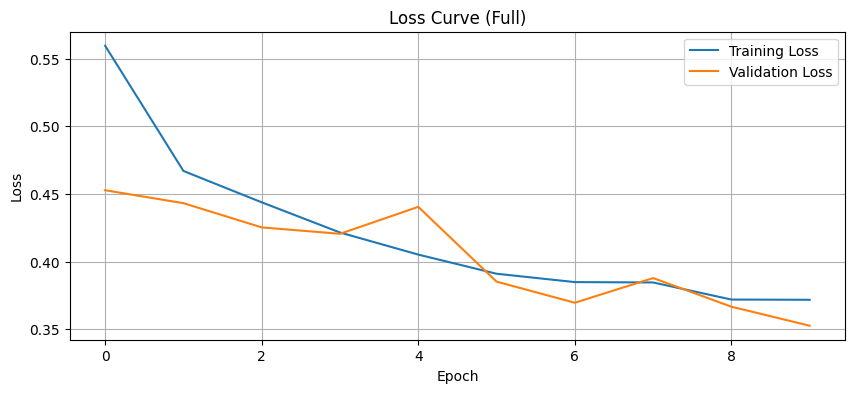

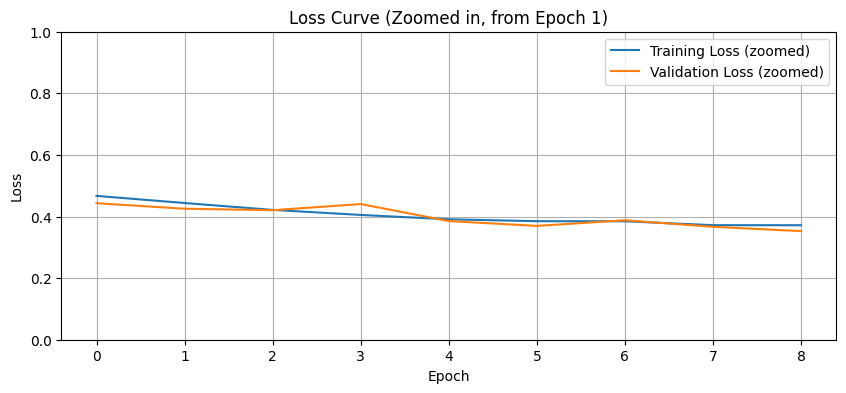

In [6]:
# Graph 1  ifor the full loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Full)")
plt.legend()
plt.grid(True)
plt.show()

# Graph 2 for zoomed-in loss curve
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'][1:], label='Training Loss (zoomed)')
plt.plot(history.history['val_loss'][1:], label='Validation Loss (zoomed)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Zoomed in, from Epoch 1)")
plt.ylim(0, 1) 
plt.legend()
plt.grid(True)
plt.show()


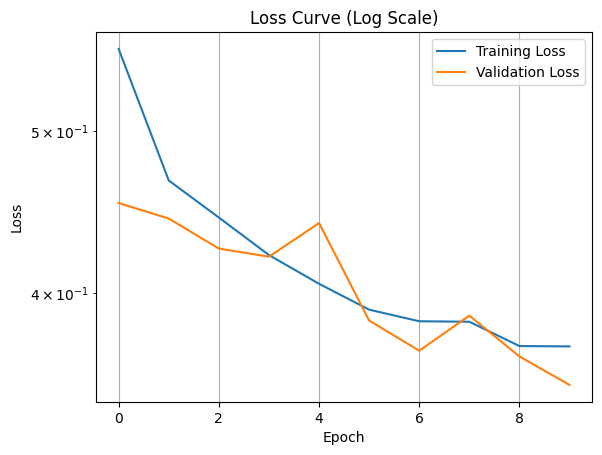

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss Curve (Log Scale)")
plt.legend()
plt.grid(True)
plt.show()

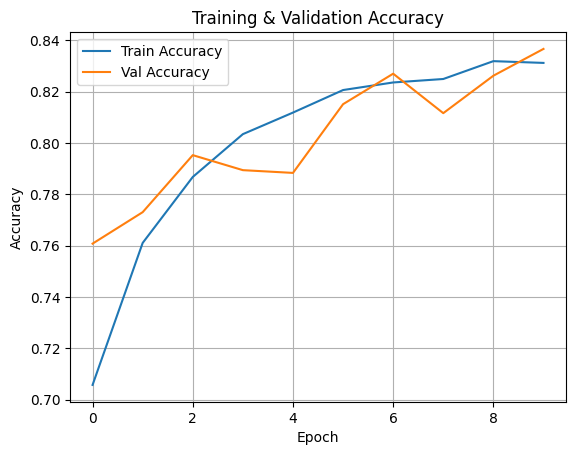

In [8]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from tensorflow.keras.models import load_model

# finding the accuracy , loss on val set
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# finding the accuracy , loss on test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.3464 - sparse_categorical_accuracy: 0.8387
Validation Loss: 0.3526
Validation Accuracy: 0.8366
28/28 ━━━━━━━━━━━━━━━━━━━━ 369s 13s/step - loss: 0.3624 - sparse_categorical_accuracy: 0.8352 
Test Loss: 0.3543
Test Accuracy: 0.8392


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, jaccard_score

true_labels = []
pred_labels = []

max_batches = len(test_gen)  # total number of batches

for i, batch in enumerate(val_gen):
    if i >= max_batches:
        break  # to stop if the batches are more than expected

    X_batch, y_true_batch = batch
    y_pred_batch = model.predict(X_batch)
    y_pred_batch = np.argmax(y_pred_batch, axis=-1)
    
    true_labels.append(y_true_batch.flatten())
    pred_labels.append(y_pred_batch.flatten())

y_true_all = np.concatenate(true_labels)
y_pred_all = np.concatenate(pred_labels)

f1 = f1_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)
iou = jaccard_score(y_true_all, y_pred_all, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU (Jaccard): {iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

IoU: 0.4467 | F1 Score: 0.5303 | Accuracy: 0.8366

 Pixel Classification Report 
              precision    recall  f1-score   support

      Intact       0.89      0.88      0.89  20814694
      Severe       0.69      0.71      0.70   7748597
   Collapsed       0.00      0.00      0.00     10405

    accuracy                           0.84  28573696
   macro avg       0.53      0.53      0.53  28573696
weighted avg       0.84      0.84      0.84  28573696



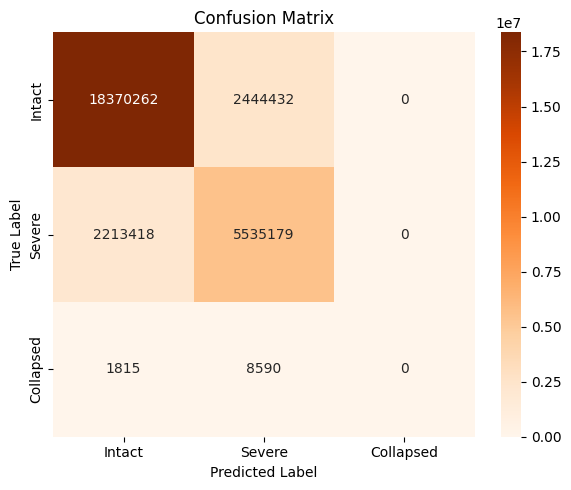

In [ ]:
# Evaluation metrics -> F1, accuracy and IoU
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns


f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
accuracy = accuracy_score(y_true_all, y_pred_all)
iou = jaccard_score(y_true_all, y_pred_all, average='macro', zero_division=0)


print(f"IoU: {iou:.4f} | F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")
print("\n Pixel Classification Report ")
print(classification_report(
    y_true_all, y_pred_all,
    target_names=["Intact", "Severe", "Collapsed"],
    zero_division=0
))

# Confusion Matrix for damage assesment 
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Intact", "Severe", "Collapsed"],
            yticklabels=["Intact", "Severe", "Collapsed"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Label colors (RGB)
label_colors = {
    0: [0, 0, 0],          # this refers to intact, that is black
    1: [128, 128, 128],    # this refers to severe, that is gray
    2: [255, 255, 255]     # this refers to collapsed, that is white
}

# Label names
label_names = {
    0: "Intact",
    1: "Severe",
    2: "Collapsed"
}


In [26]:
def changing_mask_rgb(label_mask, color_map):
    height, width = label_mask.shape  # for getting the height and width of the 2D label mask
    rgb_img = np.zeros((height, width, 3), dtype=np.uint8)  # Creates an empty RGB image of the same height and width
    for label, color in color_map.items():  # this is for looping  through each label and its assigned color
        rgb_img[label_mask == label] = color  # to replace all pixels with the current label by its correct rgb colour
    return rgb_img


In [27]:
def get_label_percentages(mask):
    total_pixels = mask.size  # get the size of the mask like height x width
    counts = Counter(mask.flatten())  # first turns the 2D mask into a 1D list of labels and then the counter counts how many times 0,1,2 appear
    percentages = {label: (count / total_pixels) * 100 for label, count in counts.items()}  # here using the count received from counter-> convert it into %
    most_common_label = counts.most_common(1)[0][0]
    return percentages, most_common_label  # gives the label with the most pixels


In [28]:
def add_labelpercentage(label_percentages):
    hold_info = []  # hold info until combined 
    sorted_labels = sorted(label_percentages)  # Sort labels (0,1,2)
    i = 0
    while i < len(sorted_labels):
        label_id = sorted_labels[i]
        percentage = label_percentages[label_id]
        label_name = label_names[label_id]
        hold_info.append(f"{label_name}: {percentage:.2f}%")
        i += 1
    return ", ".join(hold_info)


In [29]:
X_vis, y_true_vis = test_gen[2]  # Loads a batch from your generator, here is batch 2

# Predict on batch and get labels (argmax for class)
y_pred_vis = model.predict(X_vis)  # predicts on batch 2 
y_pred_vis = np.argmax(y_pred_vis, axis=-1)  # gets labels 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


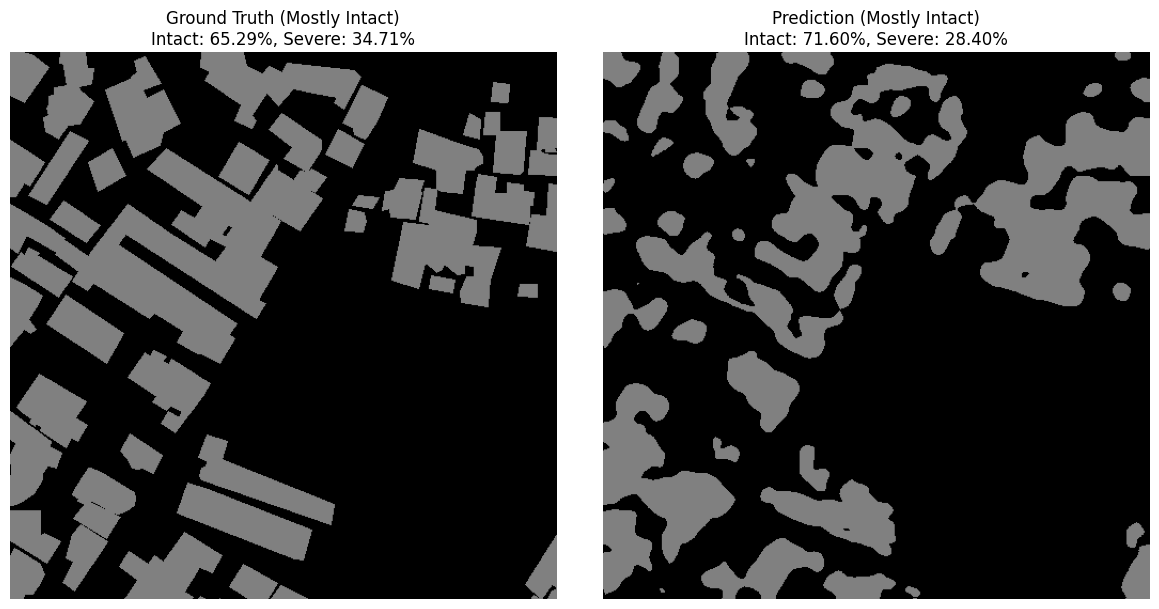

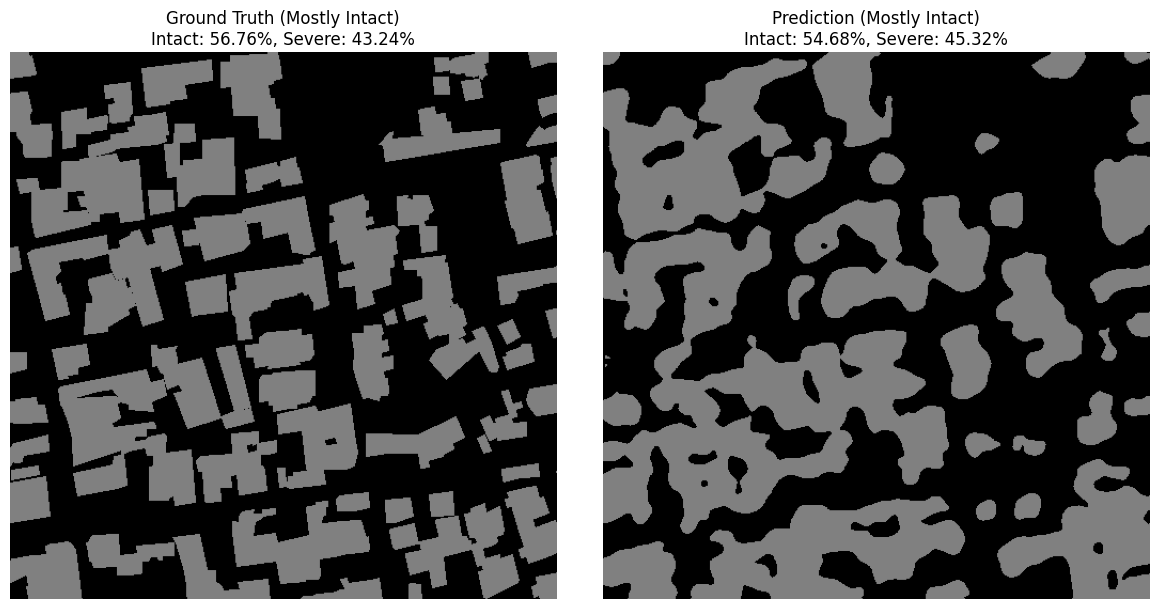

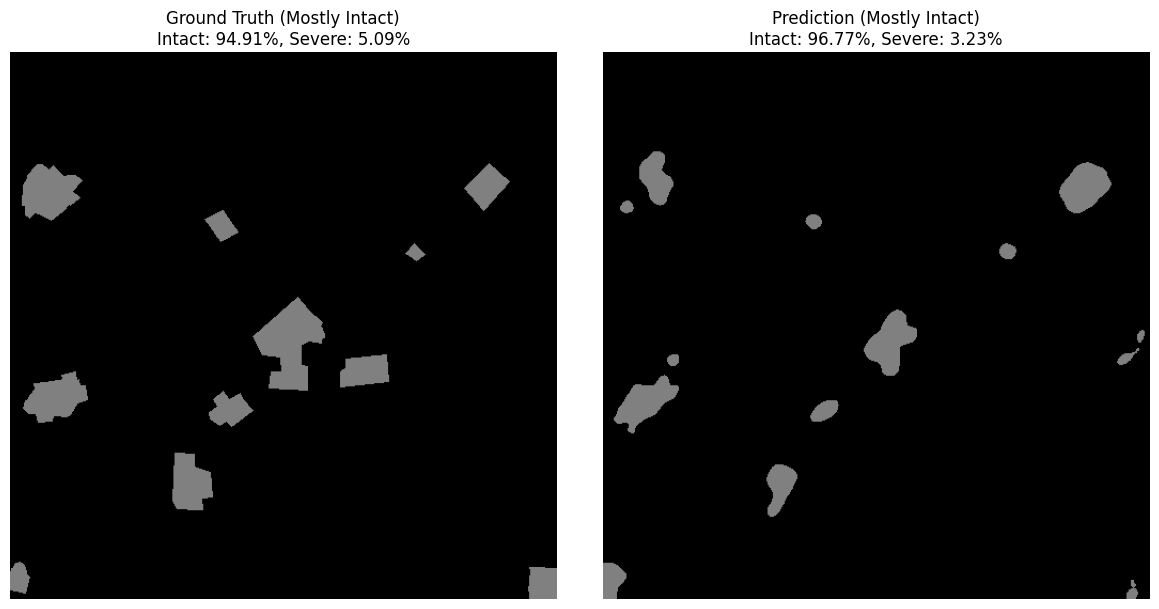

In [30]:
for i in range(min(3, len(X_vis))):  # to not visualize too many images a loop is created to showcase only 3 images from batch 2
    true_mask = y_true_vis[i]
    pred_mask = y_pred_vis[i]

    # this is to get label percentages and most common label for true and pred masks
    true_percentages, most_common_true = get_label_percentages(true_mask)
    pred_percentages, most_common_pred = get_label_percentages(pred_mask)

    # Converting the masks to rgb img for visualisation
    true_colored = changing_mask_rgb(true_mask, label_colors)
    pred_colored = changing_mask_rgb(pred_mask, label_colors)

    # plotting
    plt.figure(figsize=(12, 6))

    # this is for showcasing ground truth image with the label names and their percentages
    plt.subplot(1, 2, 1)
    plt.imshow(true_colored)
    plt.title(
        f"Ground Truth (Mostly {label_names[most_common_true]})\n" 
        f"{add_labelpercentage(true_percentages)}"
    )
    plt.axis('off')

    # this is for showcasing predicted image with the label names and their percentages
    plt.subplot(1, 2, 2)
    plt.imshow(pred_colored)
    plt.title(
        f"Prediction (Mostly {label_names[most_common_pred]})\n" 
        f"{add_labelpercentage(pred_percentages)}"
    )
    plt.axis('off')

    plt.tight_layout()
    plt.show()
